For checking correlations between different features in movie posters and the box office revenue of the movies.

Indicators from image analysis of the posters:
 - Color (RGB/HEX)
 - Lighting (brightness)
 - Contrast (variance in brightness?)
 - Sharpness? (edge detection)

Indicators from meta data of the posters:
 - Number of characters
 - Specific characters present (Iron man, Thor...)
 - Words/Text/Font?

# Imports and set up

In [2]:
# imports
import pandas as pd
from PIL import Image
import glob

import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

In [3]:
# setup - getting movie filenames and creating dataframe for later additions
movie_titles = []
movie_filepaths = []
imdb_ids = []

image_filepaths = dict()
for filename in glob.glob('../data/raw/images/*.jpg'):
    splitup = filename.split('_')
    imdb_ids.append(splitup[0][19:])
    movie_titles.append(splitup[1][:-4])
    movie_filepaths.append(filename)

img_analysis_dict = dict()
img_analysis_dict['movie_title'] = movie_titles
img_analysis_dict['movie_filepath'] = movie_filepaths
img_analysis_dict['imdb_id'] = imdb_ids
img_analysis_df = pd.DataFrame.from_dict(img_analysis_dict)

# getting movie revenue
movie_stats_df = pd.read_csv('../data/processed/movie_stats/movie_stats.csv')

# merging dataframes by column imdb_id
img_analysis_df = pd.merge(img_analysis_df, movie_stats_df[['imdb_id', 'movie_revenue']], on='imdb_id', how='left')
img_analysis_df.head()

,movie_title,movie_filepath,imdb_id,movie_revenue
0,iron-man,../data/raw/images\tt0371746_iron-man.jpg,tt0371746,585174222
1,captain-america-the-first-avenger,../data/raw/images\tt0458339_captain-america-t...,tt0458339,370569774
2,ant-man,../data/raw/images\tt0478970_ant-man.jpg,tt0478970,519311965
3,the-incredible-hulk,../data/raw/images\tt0800080_the-incredible-hu...,tt0800080,163712074
4,thor,../data/raw/images\tt0800369_thor.jpg,tt0800369,449326618


# Extracting indicators via image analysis

## Average and Dominant Colors

In [11]:
def analyse_colors(filepath):
    '''Given image,
    calculates avg and dominant colors
    returns the values'''

    img = io.imread(filepath)[:, :, :]
    average = img.mean(axis=0).mean(axis=0)
    pixels = np.float32(img.reshape(-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    return img, average, palette, counts

def gen_color_figure(img, average, palette, counts):
    '''Given image, palette, and counts,
    Creates and draws avg and dominant color figure'''

    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(img.shape[0]*freqs)

    dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
        
    # fig, (ax0, ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12,6))
    ax0.imshow(img)
    ax0.set_title('Poster', fontsize=20)
    ax0.axis('off')
    ax1.imshow(avg_patch)
    ax1.set_title('Average color', fontsize=20)
    ax1.axis('off')
    ax2.imshow(dom_patch)
    ax2.set_title('Dominant colors', fontsize=20)
    ax2.axis('off')

    return plt.show(fig)

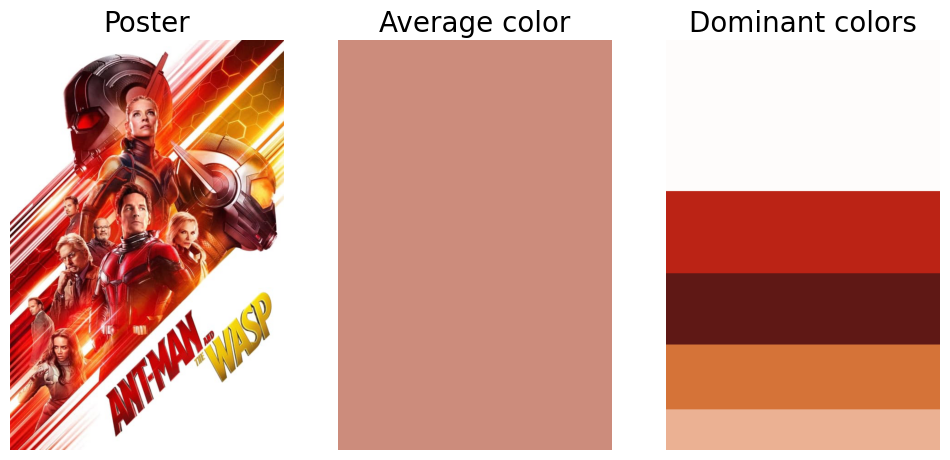

In [12]:
test = img_analysis_df[img_analysis_df['movie_title'] == 'ant-man-and-the-wasp']['movie_filepath'].values[0]

img, average, palette, counts = analyse_colors(test)
gen_color_figure(img, average, palette, counts)

In [6]:
# brightness analysis


## Contrast / Sharpness

In [7]:
contrast = []
for idx, row in img_analysis_df.iterrows():
    filepath = row['movie_filepath']
    img = io.imread(filepath)[:, :, :]
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contrast.append(img_grey.std())
img_analysis_df['contrast'] = contrast
img_analysis_df.head()

,movie_title,movie_filepath,imdb_id,movie_revenue,contrast
0,iron-man,../data/raw/images\tt0371746_iron-man.jpg,tt0371746,585174222,54.465948
1,captain-america-the-first-avenger,../data/raw/images\tt0458339_captain-america-t...,tt0458339,370569774,85.446249
2,ant-man,../data/raw/images\tt0478970_ant-man.jpg,tt0478970,519311965,73.368112
3,the-incredible-hulk,../data/raw/images\tt0800080_the-incredible-hu...,tt0800080,163712074,58.995982
4,thor,../data/raw/images\tt0800369_thor.jpg,tt0800369,449326618,47.810759


<AxesSubplot:xlabel='contrast', ylabel='movie_revenue'>

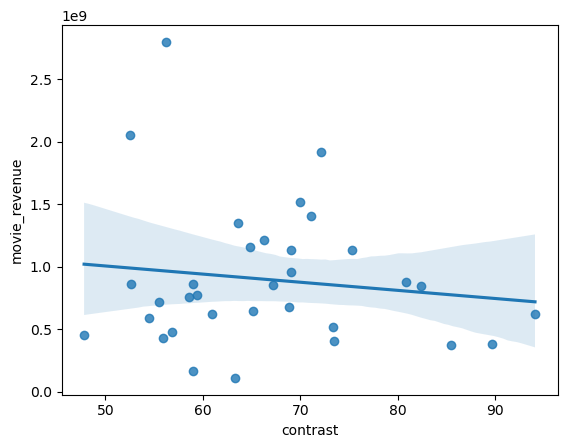

In [8]:
import seaborn as sns

# scatter plot for contrast on x axis and revenue on y
x = img_analysis_df['contrast']
y = img_analysis_df['movie_revenue']

sns.regplot(x = x, y = y)

# Extracting indicators manually

In [9]:
# smth like
img_manual_indics = {
    'movie': [],
    'n_characters': [],
    'chars_present': []
}

In [10]:
# characters present (and number of characters from that too)

# need to manually go through all the posters and write them down